In [1]:
%load_ext autoreload

In [2]:
import numpy as np
import os
import mcubes
import meshcat
import pydrake
from pydrake.geometry import SceneGraph
from pydrake.systems.framework import DiagramBuilder
from pydrake.common import FindResourceOrThrow
from pydrake.multibody.plant import MultibodyPlant, AddMultibodyPlantSceneGraph
from pydrake.multibody.parsing import Parser, LoadModelDirectives, ProcessModelDirectives
from pydrake.multibody.tree import RevoluteJoint
from pydrake.all import ConnectMeshcatVisualizer, InverseKinematics, RigidTransform, RotationMatrix
from pydrake.all import BsplineTrajectoryThroughUnionOfHPolyhedra, IrisInConfigurationSpace, IrisOptions, Rgba
import time
from meshcat import Visualizer
from functools import partial

import ipywidgets as widgets
from IPython.display import display

#from meshcat_cpp_utils import StartMeshcat, MeshcatJointSliders
from pydrake.all import MeshcatVisualizerCpp, MeshcatVisualizerParams, Role
import rrt, utils, prm# spp
from iris_t_space import set_up_iris_t_space


In [3]:
# Setup meshcat
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=[])

In [20]:
vis = Visualizer(zmq_url=zmq_url)
vis.delete()

#model_file = FindResourceOrThrow("drake/manipulation/models/iiwa_description/urdf/iiwa14_polytope_collision.urdf")
model_file = FindResourceOrThrow("drake/manipulation/models/iiwa_description/iiwa7/iiwa7_with_box_collision.sdf")

#model_file = FindResourceOrThrow("drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf")
#model_file = FindResourceOrThrow("drake/manipulation/models/iiwa_description/sdf/iiwa14_no_collision.sdf")

#box_file = FindResourceOrThrow("drake/sandbox/assets/box.urdf")
box_file_1 = FindResourceOrThrow("drake/sandbox/assets/shelves.sdf")
box_file_2 = FindResourceOrThrow("drake/sandbox/assets/shelves2.sdf")
box_file_3 = FindResourceOrThrow("drake/sandbox/assets/shelves3.sdf")
box_file_4 = FindResourceOrThrow("drake/sandbox/assets/shelves4.sdf")
lid_file = FindResourceOrThrow("drake/sandbox/assets/lid.urdf")
ground_file = FindResourceOrThrow("drake/sandbox/assets/ground.urdf")

models =[]

builder = DiagramBuilder()

plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
models.append(Parser(plant, scene_graph).AddModelFromFile(model_file))

models.append(Parser(plant, scene_graph).AddModelFromFile(box_file_1))
models.append(Parser(plant, scene_graph).AddModelFromFile(box_file_2))
models.append(Parser(plant, scene_graph).AddModelFromFile(box_file_3))
models.append(Parser(plant, scene_graph).AddModelFromFile(box_file_4))
models.append(Parser(plant, scene_graph).AddModelFromFile(lid_file))
#models.append(Parser(plant, scene_graph).AddModelFromFile(ground_file))

sp = 0.46
x_fac = 1.25
locs = [ [0,0,0], 
        [x_fac*sp, 1.4*sp,0.4], [x_fac*sp,-1.4*sp,0.4], [-x_fac*sp,-1.4*sp,0.4], [-x_fac*sp,1.4*sp,0.4], 
        [0.0 ,0 , 0.95], [0.0 ,0 , -0.08]] 
idx = 0
for model in models:
    plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(model)[0]).body_frame(), RigidTransform(locs[idx]))
    idx +=1
    
    
plant.Finalize()

visualizer = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url, delete_prefix_on_load=False, )

diagram = builder.Build()
visualizer.load()
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(context)
diagram.Publish(context)



You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6002...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/
Connected to meshcat-server.


In [21]:
sliders = []

for joint_idx in range(1,8):
    sliders.append(
        widgets.FloatSlider(
        min=plant.GetJointByName(f"iiwa_joint_{joint_idx}").position_lower_limit(), 
        max=plant.GetJointByName(f"iiwa_joint_{joint_idx}").position_upper_limit(), 
        value=0, 
        description=f'iiwa_joint_{joint_idx}'
        )
    )

ik = InverseKinematics(plant, plant_context)
collision_constraint = ik.AddMinimumDistanceConstraint(0.001, 0.001)

def eval_cons(q, c, tol):
    return 1-1*float(c.evaluator().CheckSatisfied(q, tol))
    
col_func_handle = partial(eval_cons, c=collision_constraint, tol=0.01)
    
def showres(q):
    for joint_idx in range(1,8):
        plant.GetJointByName(f"iiwa_joint_{joint_idx}").set_angle(plant_context, q[joint_idx-1])
    t = convert_q_to_t(q)
    col = col_func_handle_rational(t)
    if col:
        vis["collision"].set_object(
                meshcat.geometry.Sphere(0.1), meshcat.geometry.MeshLambertMaterial(color=0xFF0000))
        vis["collision"].set_transform(
                meshcat.transformations.translation_matrix([0, 1.0, 1.0]))
    else:
        vis["collision"].set_object(
                meshcat.geometry.Sphere(0.1), meshcat.geometry.MeshLambertMaterial(color=0x00FF00))
        vis["collision"].set_transform(
                meshcat.transformations.translation_matrix([0, 1.0, 1.0]))
    diagram.Publish(context)
    print("              ", end = "\r")
    print(col , end = "\r")

    
def set_joint_angles(vals):
    for idx in range(1,8):
        plant.GetJointByName(f"iiwa_joint_{idx}").set_angle(plant_context, vals[idx-1])
    
    
    
q_init = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
# q_start = [-1.37, -1.39, -1.57, -1.19, -1.57, 0.00, 0.00]
# q_end = [1.53, -1.19, 1.83, 0.91, -1.27, -0.59, 0.00]
q = q_init.copy()
def handle_slider_change(change, idx):
    q[idx] = change['new']
    #print(q, end="\r")
    showres(q)
    
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

def convert_q_to_t(q):
    return np.tan(np.divide(q,2))

def convert_t_to_q(t):
    q =np.arctan2(2*t/(1+t**2), (1-t**2)/(1+t**2))
    return q

def eval_cons_rational(t, c, tol):
    q = convert_t_to_q(t).squeeze() 
    return col_func_handle(q)
   
col_func_handle_rational = partial(eval_cons_rational, c=collision_constraint, tol=0.01)



In [22]:
for slider in sliders:
    display(slider)
display(vis.jupyter_cell())

FloatSlider(value=0.0, description='iiwa_joint_1', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='iiwa_joint_2', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='iiwa_joint_3', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='iiwa_joint_4', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='iiwa_joint_5', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='iiwa_joint_6', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='iiwa_joint_7', max=3.05433, min=-3.05433)

In [23]:
#problem config
start = np.array([1.43, -0.69, 0.83, 1.01, -1.97, 1.11, 0.00])
target = np.array([1.73, 1.41, 0.43, -1.19, -1.27, -1.19, 0.00])
showres(target)
q_limits =[plant.GetPositionLowerLimits(), plant.GetPositionUpperLimits()]
t_min = convert_q_to_t(q_limits[0])
t_max = convert_q_to_t(q_limits[1])
t_limits = [t_min, t_max]

In [39]:
PRM = prm.PRM( 
            t_limits,
            num_points = 30000,
            col_func_handle = col_func_handle_rational,
            num_neighbours = 30, 
            dist_thresh = 3.0,
            num_col_checks = 40,
            verbose = True,
            plotcallback = None
            )

PRM.add_start_end(start, target)
prm_path, _ = PRM.find_shortest_path()
print(f'PRM path length: {len(prm_path)}')

[PRM] Samples 0
[PRM] Samples 30
[PRM] Samples 60
[PRM] Samples 90
[PRM] Samples 120
[PRM] Samples 150
[PRM] Samples 180
[PRM] Samples 210
[PRM] Samples 240
[PRM] Samples 270
[PRM] Samples 300
[PRM] Samples 330
[PRM] Samples 360
[PRM] Samples 390
[PRM] Samples 420
[PRM] Samples 450
[PRM] Samples 480
[PRM] Samples 510
[PRM] Samples 540
[PRM] Samples 570
[PRM] Samples 600
[PRM] Samples 630
[PRM] Samples 660
[PRM] Samples 690
[PRM] Samples 720
[PRM] Samples 750
[PRM] Samples 780
[PRM] Samples 810
[PRM] Samples 840
[PRM] Samples 870
[PRM] Samples 900
[PRM] Samples 930
[PRM] Samples 960
[PRM] Samples 990
[PRM] Samples 1020
[PRM] Samples 1050
[PRM] Samples 1080
[PRM] Samples 1110
[PRM] Samples 1140
[PRM] Samples 1170
[PRM] Samples 1200
[PRM] Samples 1230
[PRM] Samples 1260
[PRM] Samples 1290
[PRM] Samples 1320
[PRM] Samples 1350
[PRM] Samples 1380
[PRM] Samples 1410
[PRM] Samples 1440
[PRM] Samples 1470
[PRM] Samples 1500
[PRM] Samples 1530
[PRM] Samples 1560
[PRM] Samples 1590
[PRM] Samples

[PRM] Samples 13800
[PRM] Samples 13830
[PRM] Samples 13860
[PRM] Samples 13890
[PRM] Samples 13920
[PRM] Samples 13950
[PRM] Samples 13980
[PRM] Samples 14010
[PRM] Samples 14040
[PRM] Samples 14070
[PRM] Samples 14100
[PRM] Samples 14130
[PRM] Samples 14160
[PRM] Samples 14190
[PRM] Samples 14220
[PRM] Samples 14250
[PRM] Samples 14280
[PRM] Samples 14310
[PRM] Samples 14340
[PRM] Samples 14370
[PRM] Samples 14400
[PRM] Samples 14430
[PRM] Samples 14460
[PRM] Samples 14490
[PRM] Samples 14520
[PRM] Samples 14550
[PRM] Samples 14580
[PRM] Samples 14610
[PRM] Samples 14640
[PRM] Samples 14670
[PRM] Samples 14700
[PRM] Samples 14730
[PRM] Samples 14760
[PRM] Samples 14790
[PRM] Samples 14820
[PRM] Samples 14850
[PRM] Samples 14880
[PRM] Samples 14910
[PRM] Samples 14940
[PRM] Samples 14970
[PRM] Samples 15000
[PRM] Samples 15030
[PRM] Samples 15060
[PRM] Samples 15090
[PRM] Samples 15120
[PRM] Samples 15150
[PRM] Samples 15180
[PRM] Samples 15210
[PRM] Samples 15240
[PRM] Samples 15270


[PRM] Samples 26280
[PRM] Samples 26310
[PRM] Samples 26340
[PRM] Samples 26370
[PRM] Samples 26400
[PRM] Samples 26430
[PRM] Samples 26460
[PRM] Samples 26490
[PRM] Samples 26520
[PRM] Samples 26550
[PRM] Samples 26580
[PRM] Samples 26610
[PRM] Samples 26640
[PRM] Samples 26670
[PRM] Samples 26700
[PRM] Samples 26730
[PRM] Samples 26760
[PRM] Samples 26790
[PRM] Samples 26820
[PRM] Samples 26850
[PRM] Samples 26880
[PRM] Samples 26910
[PRM] Samples 26940
[PRM] Samples 26970
[PRM] Samples 27000
[PRM] Samples 27030
[PRM] Samples 27060
[PRM] Samples 27090
[PRM] Samples 27120
[PRM] Samples 27150
[PRM] Samples 27180
[PRM] Samples 27210
[PRM] Samples 27240
[PRM] Samples 27270
[PRM] Samples 27300
[PRM] Samples 27330
[PRM] Samples 27360
[PRM] Samples 27390
[PRM] Samples 27420
[PRM] Samples 27450
[PRM] Samples 27480
[PRM] Samples 27510
[PRM] Samples 27540
[PRM] Samples 27570
[PRM] Samples 27600
[PRM] Samples 27630
[PRM] Samples 27660
[PRM] Samples 27690
[PRM] Samples 27720
[PRM] Samples 27750


[PRM] Nodes connected: 4140
[PRM] Nodes connected: 4160
[PRM] Nodes connected: 4180
[PRM] Nodes connected: 4200
[PRM] Nodes connected: 4220
[PRM] Nodes connected: 4240
[PRM] Nodes connected: 4260
[PRM] Nodes connected: 4280
[PRM] Nodes connected: 4300
[PRM] Nodes connected: 4320
[PRM] Nodes connected: 4340
[PRM] Nodes connected: 4360
[PRM] Nodes connected: 4380
[PRM] Nodes connected: 4400
[PRM] Nodes connected: 4420
[PRM] Nodes connected: 4440
[PRM] Nodes connected: 4460
[PRM] Nodes connected: 4480
[PRM] Nodes connected: 4500
[PRM] Nodes connected: 4520
[PRM] Nodes connected: 4540
[PRM] Nodes connected: 4560
[PRM] Nodes connected: 4580
[PRM] Nodes connected: 4600
[PRM] Nodes connected: 4620
[PRM] Nodes connected: 4640
[PRM] Nodes connected: 4660
[PRM] Nodes connected: 4680
[PRM] Nodes connected: 4700
[PRM] Nodes connected: 4720
[PRM] Nodes connected: 4740
[PRM] Nodes connected: 4760
[PRM] Nodes connected: 4780
[PRM] Nodes connected: 4800
[PRM] Nodes connected: 4820
[PRM] Nodes connecte

[PRM] Nodes connected: 10020
[PRM] Nodes connected: 10040
[PRM] Nodes connected: 10060
[PRM] Nodes connected: 10080
[PRM] Nodes connected: 10100
[PRM] Nodes connected: 10120
[PRM] Nodes connected: 10140
[PRM] Nodes connected: 10160
[PRM] Nodes connected: 10180
[PRM] Nodes connected: 10200
[PRM] Nodes connected: 10220
[PRM] Nodes connected: 10240
[PRM] Nodes connected: 10260
[PRM] Nodes connected: 10280
[PRM] Nodes connected: 10300
[PRM] Nodes connected: 10320
[PRM] Nodes connected: 10340
[PRM] Nodes connected: 10360
[PRM] Nodes connected: 10380
[PRM] Nodes connected: 10400
[PRM] Nodes connected: 10420
[PRM] Nodes connected: 10440
[PRM] Nodes connected: 10460
[PRM] Nodes connected: 10480
[PRM] Nodes connected: 10500
[PRM] Nodes connected: 10520
[PRM] Nodes connected: 10540
[PRM] Nodes connected: 10560
[PRM] Nodes connected: 10580
[PRM] Nodes connected: 10600
[PRM] Nodes connected: 10620
[PRM] Nodes connected: 10640
[PRM] Nodes connected: 10660
[PRM] Nodes connected: 10680
[PRM] Nodes co

[PRM] Nodes connected: 15680
[PRM] Nodes connected: 15700
[PRM] Nodes connected: 15720
[PRM] Nodes connected: 15740
[PRM] Nodes connected: 15760
[PRM] Nodes connected: 15780
[PRM] Nodes connected: 15800
[PRM] Nodes connected: 15820
[PRM] Nodes connected: 15840
[PRM] Nodes connected: 15860
[PRM] Nodes connected: 15880
[PRM] Nodes connected: 15900
[PRM] Nodes connected: 15920
[PRM] Nodes connected: 15940
[PRM] Nodes connected: 15960
[PRM] Nodes connected: 15980
[PRM] Nodes connected: 16000
[PRM] Nodes connected: 16020
[PRM] Nodes connected: 16040
[PRM] Nodes connected: 16060
[PRM] Nodes connected: 16080
[PRM] Nodes connected: 16100
[PRM] Nodes connected: 16120
[PRM] Nodes connected: 16140
[PRM] Nodes connected: 16160
[PRM] Nodes connected: 16180
[PRM] Nodes connected: 16200
[PRM] Nodes connected: 16220
[PRM] Nodes connected: 16240
[PRM] Nodes connected: 16260
[PRM] Nodes connected: 16280
[PRM] Nodes connected: 16300
[PRM] Nodes connected: 16320
[PRM] Nodes connected: 16340
[PRM] Nodes co

[PRM] Nodes connected: 21360
[PRM] Nodes connected: 21380
[PRM] Nodes connected: 21400
[PRM] Nodes connected: 21420
[PRM] Nodes connected: 21440
[PRM] Nodes connected: 21460
[PRM] Nodes connected: 21480
[PRM] Nodes connected: 21500
[PRM] Nodes connected: 21520
[PRM] Nodes connected: 21540
[PRM] Nodes connected: 21560
[PRM] Nodes connected: 21580
[PRM] Nodes connected: 21600
[PRM] Nodes connected: 21620
[PRM] Nodes connected: 21640
[PRM] Nodes connected: 21660
[PRM] Nodes connected: 21680
[PRM] Nodes connected: 21700
[PRM] Nodes connected: 21720
[PRM] Nodes connected: 21740
[PRM] Nodes connected: 21760
[PRM] Nodes connected: 21780
[PRM] Nodes connected: 21800
[PRM] Nodes connected: 21820
[PRM] Nodes connected: 21840
[PRM] Nodes connected: 21860
[PRM] Nodes connected: 21880
[PRM] Nodes connected: 21900
[PRM] Nodes connected: 21920
[PRM] Nodes connected: 21940
[PRM] Nodes connected: 21960
[PRM] Nodes connected: 21980
[PRM] Nodes connected: 22000
[PRM] Nodes connected: 22020
[PRM] Nodes co

[PRM] Nodes connected: 27060
[PRM] Nodes connected: 27080
[PRM] Nodes connected: 27100
[PRM] Nodes connected: 27120
[PRM] Nodes connected: 27140
[PRM] Nodes connected: 27160
[PRM] Nodes connected: 27180
[PRM] Nodes connected: 27200
[PRM] Nodes connected: 27220
[PRM] Nodes connected: 27240
[PRM] Nodes connected: 27260
[PRM] Nodes connected: 27280
[PRM] Nodes connected: 27300
[PRM] Nodes connected: 27320
[PRM] Nodes connected: 27340
[PRM] Nodes connected: 27360
[PRM] Nodes connected: 27380
[PRM] Nodes connected: 27400
[PRM] Nodes connected: 27420
[PRM] Nodes connected: 27440
[PRM] Nodes connected: 27460
[PRM] Nodes connected: 27480
[PRM] Nodes connected: 27500
[PRM] Nodes connected: 27520
[PRM] Nodes connected: 27540
[PRM] Nodes connected: 27560
[PRM] Nodes connected: 27580
[PRM] Nodes connected: 27600
[PRM] Nodes connected: 27620
[PRM] Nodes connected: 27640
[PRM] Nodes connected: 27660
[PRM] Nodes connected: 27680
[PRM] Nodes connected: 27700
[PRM] Nodes connected: 27720
[PRM] Nodes co

In [ ]:
PRM.adjacency_list


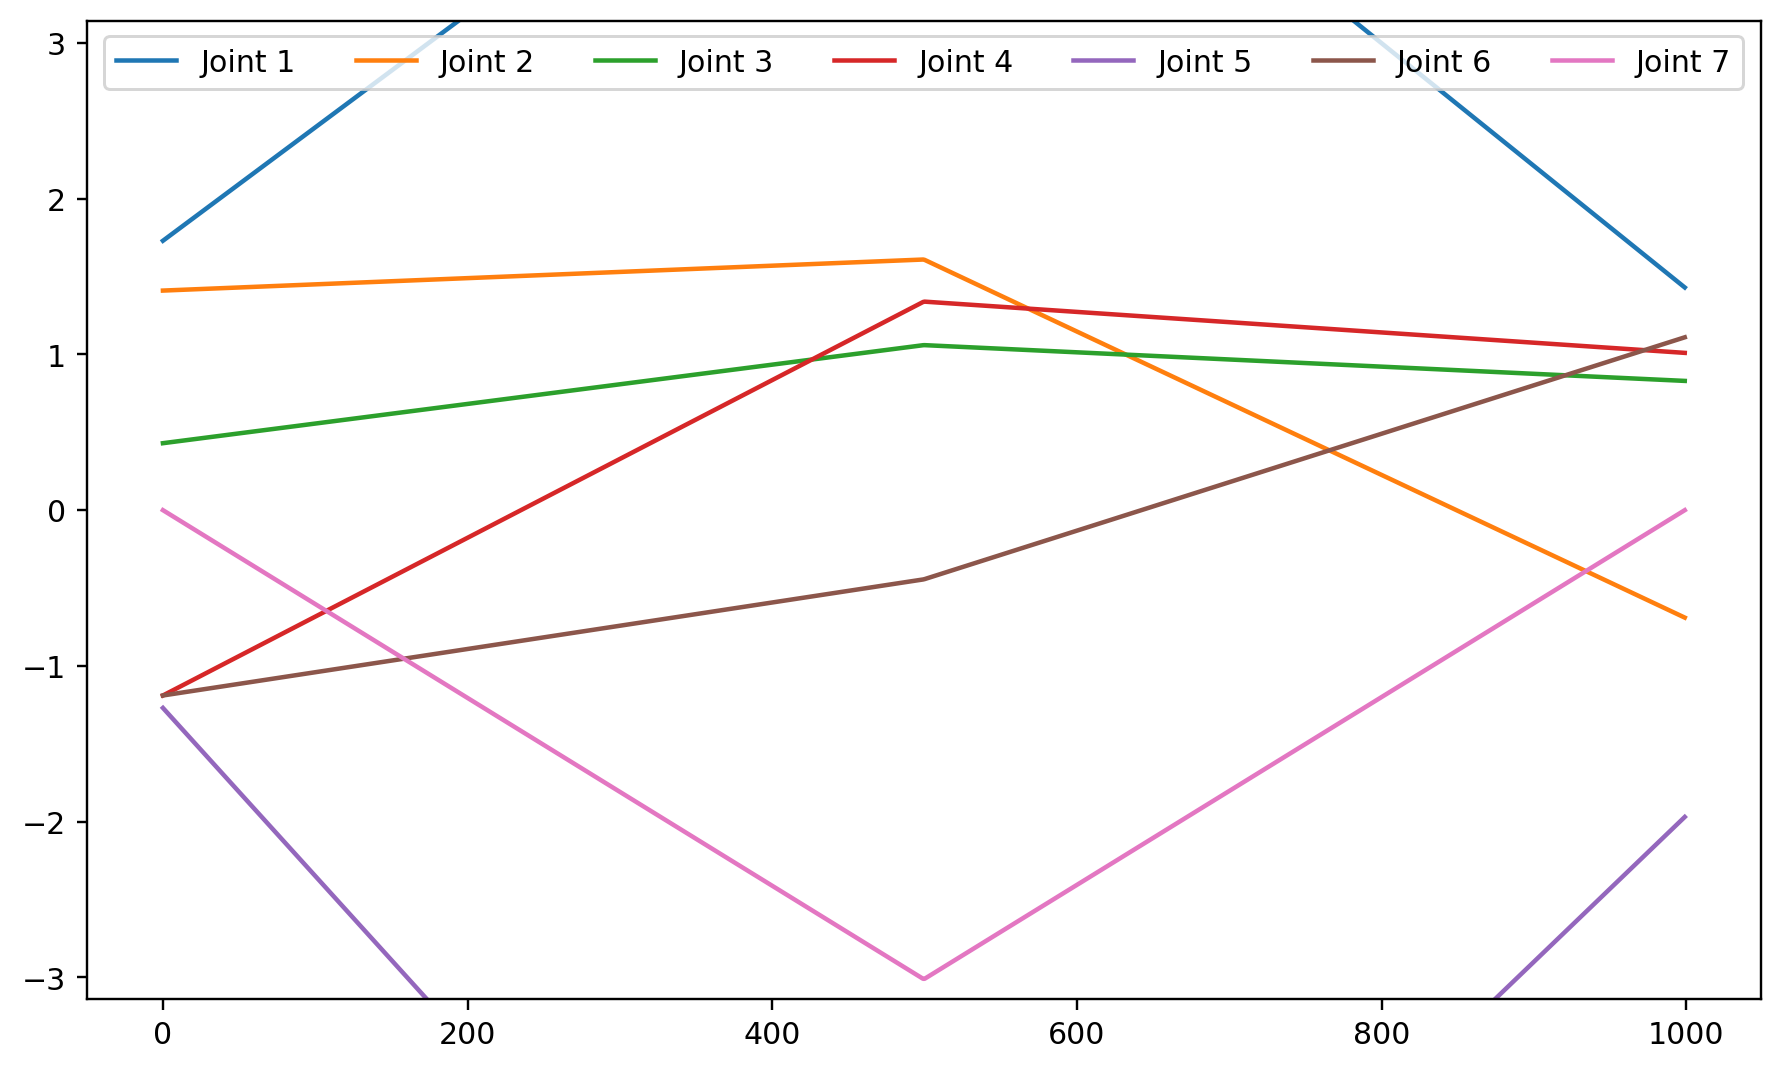

In [36]:
prm_traj= utils.PWLinTraj(prm_path, 5.0)
substeps = 1000
utils.plot(prm_traj, substeps, 1*substeps)
utils.animate(prm_traj, showres, substeps, 10*substeps)


In [ ]:
print(f'PRM path shape: {np.array(prm_path).shape}')
subsampled_prm_path = prm_path[1:-1]
print(f'PRM path shape subsampled for IRIS seed points: {np.array(subsampled_prm_path).shape}')

In [ ]:
RRT = rrt.RRT(start = target,
              goal = start,
              limits = limits,
              col_func_handle=col_func_handle,
              max_extend_length=0.5,
              extend_steps=0.05,
              init_goal_sample_rate=0.03,
              goal_sample_rate_scaler=0.6,
              verbose = True, 
              plotcallback = None)

_, rrt_path = RRT.run(10000)
print(f'RRT path length: {len(rrt_path)}')

In [ ]:
rrt_traj= utils.PWLinTraj(rrt_path, 5.0)
substeps = 1000
utils.animate(rrt_traj, showres, substeps, 5*substeps)
utils.plot(rrt_traj, substeps, 1*substeps)

In [ ]:
print(f'RRT path shape: {np.array(rrt_path).shape}')
subsampled_rrt_path = rrt_path[1:-1:10]
print(f'RRT path shape subsampled for IRIS seed points: {np.array(subsampled_rrt_path).shape}')

In [ ]:
def do_iris(q_seed, iris_options):
    start_time = time.time()
    hpoly = IrisInConfigurationSpace(plant, plant_context, q_seed, iris_options)
    ellipse = hpoly.MaximumVolumeInscribedEllipsoid()
    print("Time: %6.2f \tVolume: %6.2f \tCenter:" % (time.time() - start_time, ellipse.Volume()),
          ellipse.center(), flush=True)
    return ellipse, hpoly

iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.iteration_limit = 50
iris_options.enable_ibex = False

regions = []
ellipses = []
its = 40
# seed_points = rrt_path
# seed_points = [start] + subsampled_rrt_path + [target]
seed_points = [start] + subsampled_prm_path + [target]
# seed_points = [start, target]


# for point in seed_points:
#     ell, reg = do_iris(point, iris_options)
#     regions.append(reg)
#     ellipses.append(ell)
    
# for it in range(its):
#     print(f'Iteration {it}/{its-1}')
#     #rejection sampling to get initial feasible point 
#     found = False
#     while not found:
#         t = np.random.rand(len(limits[0]))
#         q_samp = (1-t)*limits[0] + t*limits[1]
#         found = (col_func_handle(q_samp)==0.0)
#     print("point found: ", q_samp)
#     ell, reg = do_iris(q_samp, iris_options)
#     if ell.Volume() < 1000.0:
#         regions.append(reg)
#         ellipses.append(ell)
        
#         set_joint_angles(ell.center())
#         tf = plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(6)))
#         mat = meshcat.geometry.MeshLambertMaterial(color=0x0029F1)
#         mat.reflectivity = 1.0
#         vis['centers']['points' + str(it)].set_object(
#                     meshcat.geometry.Sphere(0.02), mat)
#         vis['centers']['points' + str(it)].set_transform(tf.GetAsMatrix4())

it = 0
for point in seed_points:
    ell, reg = do_iris(point, iris_options)
    
    if ell.Volume() < 1000.0:
        regions.append(reg)
        ellipses.append(ell)
        
        set_joint_angles(ell.center())
        tf = plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(6)))
        mat = meshcat.geometry.MeshLambertMaterial(color=0x0029F1)
        mat.reflectivity = 1.0
        vis['centers']['points' + str(it)].set_object(
                    meshcat.geometry.Sphere(0.02), mat)
        vis['centers']['points' + str(it)].set_transform(tf.GetAsMatrix4())
    it += 1

In [ ]:
start_time = time.time()
spp = BsplineTrajectoryThroughUnionOfHPolyhedra(start, target, regions)
spp.set_max_velocity(.8 * np.ones(7))
spp.set_extra_control_points_per_region(2)

print(spp.num_regions())
traj = spp.Solve()
print(time.time() - start_time)
print(traj)

print(traj.start_time())
print(traj.end_time())
#visualize
maxit = 60
pts = []
for it in range(maxit):
    print(f'Iteration {it}/{maxit-1}')
    pts.append(traj.value(it*traj.end_time()/maxit))
    mat = meshcat.geometry.MeshLambertMaterial(color=0xFFF812)
    mat.reflectivity = 1.0
    set_joint_angles(pts[-1].reshape(-1,))
    tf= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(3)))
   
     
    mat = meshcat.geometry.MeshLambertMaterial(color=0x0029F1)
    mat.reflectivity = 1.0
    vis['traj']['points' + str(it)].set_object(
                meshcat.geometry.Sphere(0.02), mat)
    vis['traj']['points' + str(it)].set_transform(
                meshcat.transformations.translation_matrix(tf.translation()))
    

In [ ]:
pts = []
for it in range(100):
    pts.append(traj.value(it*traj.end_time()/maxit))
    mat = meshcat.geometry.MeshLambertMaterial(color=0xFFF812)
    mat.reflectivity = 1.0
    set_joint_angles(pts[-1].reshape(-1,))
    tf= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(3)))
   
     
    mat = meshcat.geometry.MeshLambertMaterial(color=0x0029F1)
    mat.reflectivity = 1.0
    vis['traj']['points' + str(it)].set_object(
                meshcat.geometry.Sphere(0.02), mat)
    vis['traj']['points' + str(it)].set_transform(
                meshcat.transformations.translation_matrix(tf.translation()))

In [ ]:
# traj
substeps = 1000
utils.animate(traj, showres, substeps, 5*substeps)
utils.plot(traj, substeps, 1*substeps)

In [ ]:
# Manual reversal of IRIS trajectory

import matplotlib.pyplot as plt

#loop
idx = 0
going_fwd = True
time_points BsplineTrajectoryThroughUnionOfHPolyhedra= np.linspace(0, traj.end_time(), substeps) 

for _ in range(substeps):
    #print(idx)
    q = traj.value(time_points[substeps-idx-1])
    showres(q.reshape(-1,))
    if going_fwd:
        if idx + 1 < substeps:
            idx += 1
        else:
            going_fwd = False
            idx -=1
    else:
        if idx-1 >= 0:
            idx -=1
        else:
            going_fwd = True
            idx +=1


#loop
idx = 0
going_fwd = True
time_points = np.linspace(0, traj.end_time(), substeps) 
traj_list = []

for _ in range(substeps):
    #print(idx)
    traj_list.append(traj.value(time_points[substeps-idx-1]).reshape(-1,))
    if going_fwd:
        if idx + 1 < substeps:
            idx += 1
        else:
            going_fwd = False
            idx -=1
    else:
        if idx-1 >= 0:
            idx -=1
        else:
            going_fwd = True
            idx +=1

traj_arr = np.array(traj_list)

fig, ax = plt.subplots(1,1, figsize=(10,6), dpi=72*3)
data_dims = traj_arr.shape[1]
for joint_idx in range(data_dims):
    ax.plot(np.arange(len(traj_arr[:,joint_idx])),traj_arr[:,joint_idx], label=f'Joint {joint_idx+1}')
ax.legend(loc='upper center', ncol=data_dims)
ax.set_ylim([-np.pi, np.pi])
plt.show()

In [ ]:
import spp


In [ ]:
from pydrake.geometry.optimization import 
